In [1]:
from collections import defaultdict
import csv 

import pdb
import gensim
from gensim import matutils, corpora
from gensim.models.ldamodel import LdaModel
import pandas as pd
import nltk
import statsmodels 
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import numpy as np

import snowball

In [2]:
# all data
tweet_data = pd.read_csv("CancerReport-clean-all-data-en.txt", delimiter="\t", low_memory=False)

In [3]:
# pull out just the retweets
retweets = tweet_data[tweet_data["retweet"] == True]
unique_retweet_id_list = list(set(retweets["retweet_id_str"].tolist())) 

In [4]:
# group the tweets by the tweet they are, erm, retweeting
grouped_retweets = retweets.groupby("retweet_id_str")
# then count up retweets and extract original (retweeted) text
# see code in snowball.py for doing this
orig_tweet_texts, retweet_counts = snowball._count_up_retweets(grouped_retweets)

In [5]:
# primary tweets (non-retweets)
primary_tweets = tweet_data[tweet_data["retweet"] == False]
# now merge tweet sets (retweeted and not)
orig_tweet_texts.extend(primary_tweets["tweet_text"].values)
retweet_counts.extend([0]*primary_tweets.shape[0])
f = lambda x : x if x <= 25 else 26
clipped_retweet_counts = [f(n) for n in retweet_counts]

[(0, 26)]

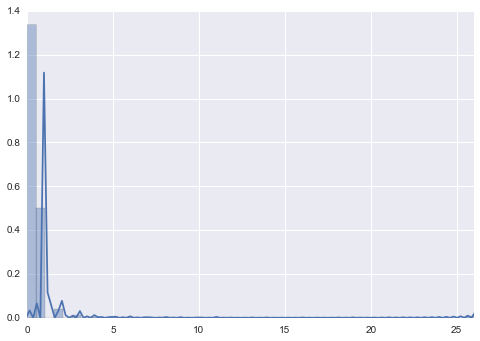

In [6]:
sns.distplot(clipped_retweet_counts).set(xlim=(0, 26))

[(0, 26)]

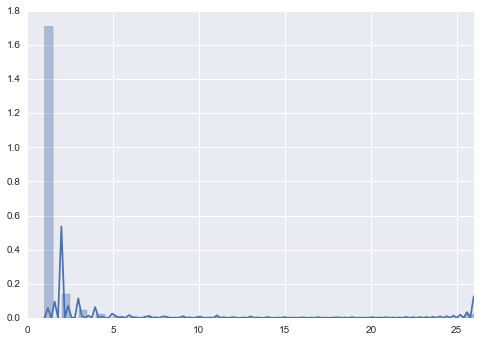

In [7]:
plt.clf()
sns.distplot([n for n in clipped_retweet_counts if n>0]).set(xlim=(0, 26))

In [8]:
### 
# now topic modeling
###

# kept_indices are the set of indices corresponding to tweets not discarded as noise 
toked_tweets, kept_indices = snowball.build_gensim_corpus(orig_tweet_texts, split_up_by_tag=False)
lda, gensim_corpus, dict_ = snowball.gen_lda_model(toked_tweets)
inferred_topic_matrix = lda.inference(gensim_corpus)[0]
# renorm, due to weirdness in gensim (???)
row_sums = inferred_topic_matrix.sum(axis=1)
inferred_topic_matrix = inferred_topic_matrix / row_sums[:, np.newaxis]

# remove the tweets that were cleaned/not included in gensim corpus
retweet_counts = [retweet_counts[idx] for idx in kept_indices]
orig_tweet_texts = [orig_tweet_texts[idx] for idx in kept_indices]


In [9]:
###
# and now regress retweet counts on inferred topic distributions (per tweet)
###

# this is just ordinary least squares (OLS)
regression_results = sm.OLS(retweet_counts, inferred_topic_matrix).fit()
print(regression_results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.615
Date:                Tue, 12 Jan 2016   Prob (F-statistic):           1.68e-09
Time:                        08:01:47   Log-Likelihood:            -1.7037e+05
No. Observations:               37922   AIC:                         3.408e+05
Df Residuals:                   37912   BIC:                         3.408e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             4.6240      0.590      7.844      0.0

In [10]:
# print out top words for each topic; special attention to topic 1 and 8
for topic_idx, topic in enumerate(lda.print_topics()):
    print("topic %s:\n %s\n" % (topic_idx+1, topic))

topic 1:
 0.028*colonoscopy + 0.023*mammogram + 0.020*mammograms + 0.016*parenthood + 0.016*planned + 0.014*colon + 0.011*co + 0.011*like + 0.010*want + 0.009*get

topic 2:
 0.130*co + 0.125*http + 0.055*fightcancer + 0.012*la + 0.009*ocrchat + 0.009*les + 0.008*warts + 0.007*pour + 0.007*rt + 0.006*en

topic 3:
 0.080*co + 0.068*http + 0.036*ecrchat + 0.023*colonoscopy + 0.016*https + 0.014*phdchat + 0.009*great + 0.008*morning + 0.008*children + 0.008*daily

topic 4:
 0.034*hpv + 0.025*mammogram + 0.023*amp + 0.012*get + 0.012*human + 0.010*time + 0.010*ve + 0.010*today + 0.010*us + 0.009*papillomavirus

topic 5:
 0.093*mcrcomeback + 0.033*imusicrcti + 0.030*imusic_rcti + 0.028*kotakmisteriimusic + 0.023*de + 0.020*le + 0.014*icrc + 0.012*loscrcl + 0.011*acrcsi + 0.010*est

topic 6:
 0.119*hpv + 0.112*co + 0.106*http + 0.053*vaccine + 0.028*gardasil + 0.016*girls + 0.013*vaccination + 0.012*via + 0.011*vaccines + 0.008*shot

topic 7:
 0.132*cancer + 0.106*co + 0.102*http + 0.062*cerv

In [12]:
top_topic_tweet_indices = inferred_topic_matrix[:,0].argsort()[-20:]
print("\n\n".join([orig_tweet_texts[idx] for idx in top_topic_tweet_indices]))

Don't forget to call @PPact today to schedule your imaginary mammogram that they supposedly provide!

RT @MCRchat: Q5: Posssiibly, they'll try the stripped down thing again and do it in a way that satisfies them this time? #MCRchat

.@PPBlackComm Please tell the author PP doesn't do mammograms! https://t.co/RfmfdxIbiq

@CDC_Cancer Fearing a #colonoscopy? Don't fret! There are many alternatives. Just #getscreened! #coloncancer http://t.co/t1kfmHI7nx

.@PPact does not offer mammograms, but there are 8,000+ facilities in the US that do. @MissAmericaOrg @HannahRobison3 http://t.co/1mVi4Y2JPg

Paul Heyman is such a good hype man he could get someone excited for a colonoscopy.

Q7: It's just kinda sad that people don't have the decency and common sense to know that stuff already! #MCRchat

OBAMA LIES:  Planned Parenthood does NOT provide mammograms, as he said in the first debate.  #EmptyChair #EmptyHead

Another Obama Debate Falsehood: Planned Parenthood Doesn't Do Mammograms http://t.co/RX